# Demo model
This notebook can be used for inference of the trained models.
To use this notebook on custom data / model, the data has to be saved in .jpg format in the folder demo_data and the model in demo_trained_models.



In [1]:
from __future__ import division, print_function

import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import load_model
import cv2
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


In [2]:
dataset = os.path.join('', 'demo_data/')
model_path = os.path.join('', 'demo_trained_models/')
print('Data path: {} \nModel path: {}'.format(dataset, model_path))

Data path: demo_data/ 
Model path: demo_trained_models/


In [3]:
# trained_weights = 'siamese_128_batch64_ep06-0.15.h5'
# trained_weights = 'siamese_128_lr_0.003_FC_marg1_batch64_ep48-0.052.h5'
trained_weights = 'siamese_128_lr_0.003_FC512_marg1_batch64_ep50-0.053.h5'
model = load_model(model_path + trained_weights, compile=False)

In [4]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
base_model (Model)              (None, 512)          10779357    input_20[0][0]                   
                                                                 input_21[0][0]                   
          

In [5]:
SIZE = 128
input_shape = (SIZE, SIZE, 3)

In [6]:
def check_file_name(img_path):
    img_path = img_path[:-4]
    if os.path.exists(img_path +'.JPG'):
        return img_path +'.JPG'
    if os.path.exists(img_path +'.jpeg'):
        return img_path +'.jpeg'
    if os.path.exists(img_path +'.JPEG'):
        return img_path +'.JPEG'
    if os.path.exists(img_path +'.png'):
        return img_path +'.png'
    if os.path.exists(img_path +'.PNG'):
        return img_path +'.PNG'
    if os.path.exists(img_path +'.gif'):
        return img_path +'.gif'
    if os.path.exists(img_path +'.GIF'):
        return img_path +'.GIF'
    if os.path.exists(img_path +'.bmp'):
        return img_path +'.bmp'
    if os.path.exists(img_path +'.BMP'):
        return img_path +'.BMP'
    else:
        return img_path

def load_image(image_name):
    if image_name not in image_cache:
        image = cv2.imread(image_name)
        if image is None:
            print(image_name)
            image_name = check_file_name(image_name)
            image = cv2.imread(image_name)
        image = cv2.resize(image, (128, 128)) #size used by Intel
        image = img_to_array(image)
        image = image.astype('float32')
        image = image/255
        image_cache[image_name] = image
    return image_cache[image_name]

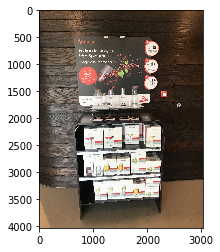

In [7]:
i = cv2.imread('./demo_data/class1/IMG_3219.png')
plt.imshow(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))

In [8]:
image_cache ={}
# x1,x2,x3 = [load_image(x) for x in test_images1]

In [9]:
def img_to_encoding(image):
    x = np.zeros((1,128,128,3))
    y = np.zeros((1,128,128,3))
    #image = np.zeros((1,128,128,3))
    image = load_image(image)
    encoding = model.predict([x,y,np.expand_dims(image,axis=0)])[2]
    return encoding

In [10]:
def encoding_to_db(image, db): #add name later
    image = load_image(image)
    return img_to_encoding(image, model)

In [11]:
def read_files():
    """Reads all files in data folder and subfolders."""
    file_list = glob.glob(dataset+'*/' +'*.png', recursive=True)
#     file_list.extend(glob.glob(dataset+'/*/' +'*.jpg', recursive=True))
#     file_list.extend(glob.glob(dataset+'/*/' +'*.JPG', recursive=True))
    return file_list
def encode_img(file_list):
    encodings = {}
    for img in file_list:
        #print(img)
        encodings[img] = img_to_encoding(img)
    return encodings
files = read_files()
encodings = encode_img(files)

In [12]:
def calculate_distance(encodings,dist_list, query ='demo_data/class1/IMG_0217.png', plot=False):
    """Calculate distances between embeddings. With plot parameter the image pairs can be shown."""
    query_enc = encodings[query]
    min_dist = 1000
    for (name, db_enc) in encodings.items():
        # Compute L2 distance between the target "encoding" and the current "emb" from the database. (≈ 1 line)
        if name == query:
            continue
        dist = float(np.linalg.norm((query_enc-db_enc)))
        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist < min_dist:
            min_dist = dist
            identity = name
    class_query = query.split('/')[-2]
    class_pred = identity.split('/')[-2]
    correct = 0
    if class_query == class_pred:
        correct = 1
    dist_list.append(min_dist)
    if plot:
        print('Query image is: {}'.format(query))
        plt.imshow(cv2.cvtColor(cv2.imread(query), cv2.COLOR_BGR2RGB))
        plt.show(block=True)
        try:
            print('Most similar image is: {}'.format(identity))
            print('Distance with query image is: {}'.format(min_dist))
            plt.imshow(cv2.cvtColor(cv2.imread(identity), cv2.COLOR_BGR2RGB))
            plt.show()
        except:
            print('No image similar with query image.')
            return '', min_dist, dist_list, correct
    return identity, min_dist, dist_list, correct

Query image is: demo_data/class1/IMG_1566.png


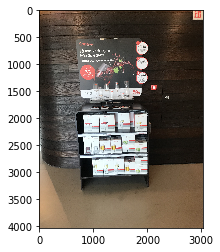

Most similar image is: demo_data/class1/IMG_9573.png
Distance with query image is: 0.9453647136688232


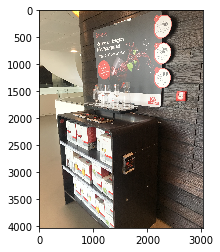




Query image is: demo_data/class2/IMG_2189.png


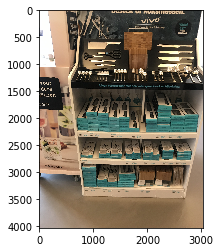

Most similar image is: demo_data/class2/IMG_6535.png
Distance with query image is: 0.9067479968070984


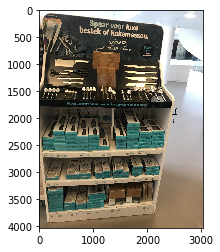




Query image is: demo_data/class4/IMG_2167.png


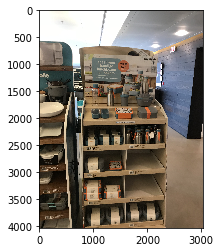

Most similar image is: demo_data/class4/IMG_2295.png
Distance with query image is: 0.4820605218410492


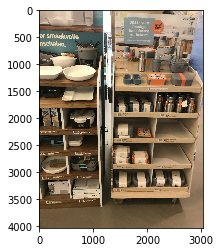

6.04 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [16]:
%%timeit -n1 -t -r1
# Query one image
try:
    dist_list
except:
    dist_list = []
_,_,_,_ = calculate_distance(encodings, dist_list,'demo_data/class1/IMG_1566.png',
                             plot=True)
print('\n\n')
_,_,_,_ = calculate_distance(encodings, dist_list,'demo_data/class2/IMG_2189.png',
                             plot=True)
print('\n\n')
_,_,_,_ = calculate_distance(encodings, dist_list,'demo_data/class4/IMG_2167.png',
                             plot=True)


In [17]:
# Evaluate on all data
dist_list = []
tot_correct = []
cache = []
ground = []
pred = []
query = []
pred_id = []
plot = False
for img in files:
    if img not in cache:
        if plot:
            print('New pair')
        identity, min_dist, dist_list, correct = calculate_distance(encodings,dist_list, img, plot = plot)
        ground.append(img.split('/')[-2])
        pred.append(identity.split('/')[-2])
        query.append('/'.join(img.split('/')[-2:]))
        pred_id.append('/'.join(identity.split('/')[-2:]))
        cache.append(identity)
        tot_correct.append(correct)

In [18]:
distances = pd.DataFrame([dist_list,tot_correct,ground,pred, query, pred_id]).T
distances.columns = ['Distances','Correct','Ground truth', 'Prediction', 'Query', 'Most similar']
distances['Distances'] = distances['Distances'].astype(float)# = [float, int]
distances['Correct'] = distances['Correct'].astype(int)
distances.describe()

,Distances,Correct
count,33.000000,33.000000
mean,0.414652,0.242424
std,0.301161,0.435194
min,0.000000,0.000000
25%,0.183861,0.000000
50%,0.369220,0.000000
75%,0.645040,0.000000
max,1.000000,1.000000


In [19]:
distances.groupby(by='Correct')['Distances'].mean()

Correct
0    0.386707
1    0.501982
Name: Distances, dtype: float64

In [20]:
distances.loc[distances['Correct']==1]

,Distances,Correct,Ground truth,Prediction,Query,Most similar
0,0.101704,1,class3,class3,class3/IMG_8063.png,class3/IMG_1365.png
7,0.482061,1,class4,class4,class4/IMG_2167.png,class4/IMG_2295.png
13,0.183861,1,class2,class2,class2/IMG_6869.png,class2/IMG_7157.png
14,0.906748,1,class2,class2,class2/IMG_2189.png,class2/IMG_6535.png
20,0.109206,1,class7,class7,class7/IMG_7393.png,class7/IMG_1385.png
22,0.370704,1,class7,class7,class7/IMG_3918.png,class7/IMG_1385.png
23,0.916208,1,class1,class1,class1/IMG_7792.png,class1/IMG_9002.png
26,0.945365,1,class1,class1,class1/IMG_1566.png,class1/IMG_9573.png


In [21]:
distances

,Distances,Correct,Ground truth,Prediction,Query,Most similar
0,0.101704,1,class3,class3,class3/IMG_8063.png,class3/IMG_1365.png
1,0.902999,0,class3,class5,class3/IMG_9654.png,class5/IMG_9415.png
2,0.000000,0,class3,class4,class3/IMG_0666.png,class4/IMG_5221.png
3,0.353774,0,class3,class6,class3/IMG_2092.png,class6/IMG_3035.png
4,0.061874,0,class3,class2,class3/IMG_3162.png,class2/IMG_0071.png
5,0.316307,0,class3,class4,class3/IMG_6046.png,class4/IMG_9808.png
6,0.093334,0,class3,class1,class3/IMG_0807.png,class1/IMG_3219.png
7,0.482061,1,class4,class4,class4/IMG_2167.png,class4/IMG_2295.png
8,0.226278,0,class4,class5,class4/IMG_8513.png,class5/IMG_3668.png
9,0.060857,0,class4,class2,class4/IMG_7030.png,class2/IMG_0071.png
